## Install Fred API 

In [1]:
!pip install fredapi > /dev/null

## Install the neccessary package required for the EDA 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from fredapi import Fred

from kaggle_secrets import UserSecretsClient
secrets = UserSecretsClient()
fred_key = secrets.get_secret('fred-api')

## 1. Create the Fred Object

In [3]:
fred = Fred(api_key=fred_key)

## 2. Browse the data for "Unemployment rate per states United States"

Search through the dataset to extract unemployment rate data for each state.

In [4]:
unemp_df = fred.search('unemployment rate by state', filter=('frequency','Monthly'))
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains("Unemployment Rate in")]

In [5]:
all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1) # Slowing doing the API request
unemp_states = pd.concat(all_results, axis=1).drop(['LASMT261982000000003', 'LASMT391746000000003', 'PRUR', 'CMWRUR', 'CSOUUR', 'CNERUR', 'CWSTUR', 'CNEWUR'], axis=1)

In [46]:
unemp_region

,CMWRUR,CSOUUR,CNERUR,CWSTUR,CNEWUR
1976-01-01,6.8,6.9,9.6,8.6,9.6
1976-02-01,6.8,6.9,9.6,8.6,9.6
1976-03-01,6.8,6.9,9.6,8.6,9.6
1976-04-01,6.7,6.8,9.5,8.5,9.4
1976-05-01,6.6,6.7,9.5,8.5,9.3
...,...,...,...,...,...
2023-10-01,3.6,3.4,4.0,4.5,3.4
2023-11-01,3.6,3.4,4.0,4.5,3.4
2023-12-01,3.6,3.4,4.0,4.5,3.3
2024-01-01,3.6,3.4,4.0,4.6,3.4


In [50]:
region_index = unemp_df.tail(5)['title'].to_dict()
unemp_region.columns = [region_index[c] for c in unemp_region.columns]

In [55]:
fig = px.line(unemp_region)
fig.show()

In [ ]:
id_to_states = unemp_df['title'].str.replace('Unemployment Rate in ', '').to_dict()
unemp_states.columns = [id_to_states[c] for c in unemp_states.columns]
unemp_states = unemp_states.rename(columns={"the District of Columbia" : "District Of Columbia"})

In [8]:
fig = px.line(
    unemp_states 
    )

# fig.update_layout(
#     xaxis="Year", 
#     yaxis="Percent", 
#     title='Unemployment in the US per states'
#     )

fig.show()

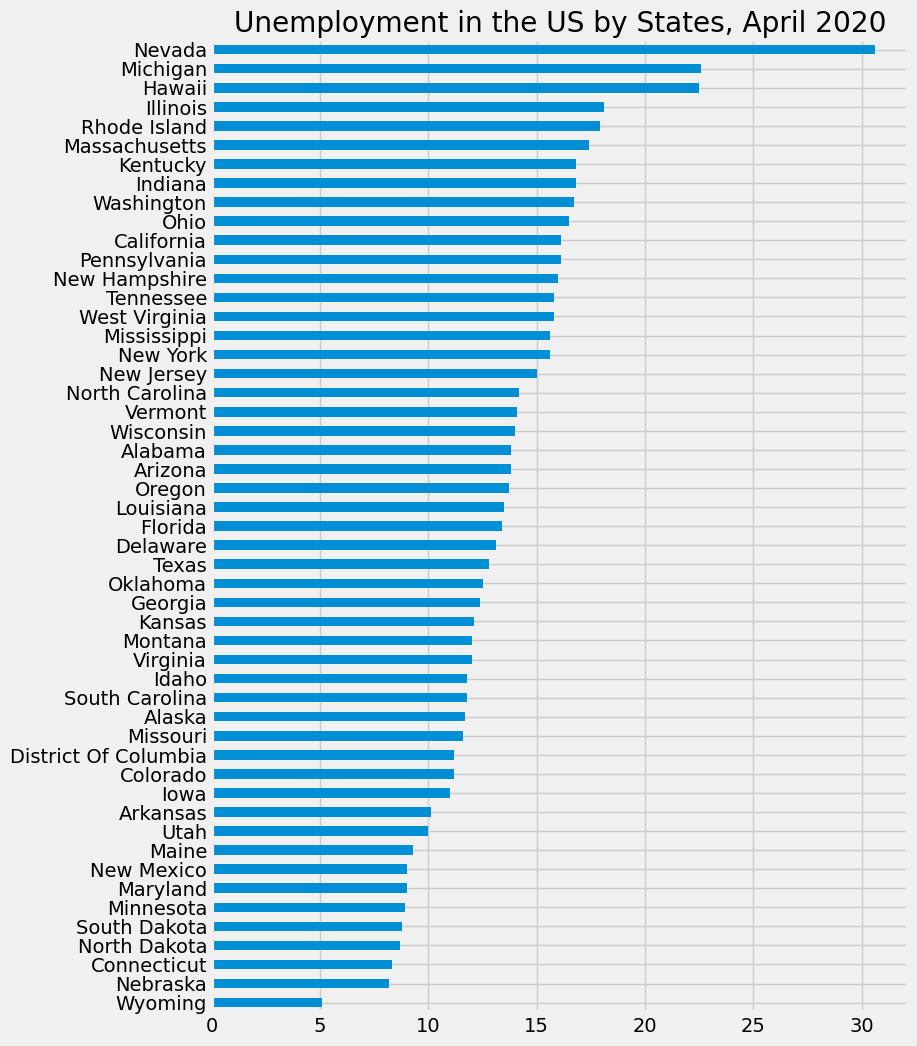

In [9]:
ax = unemp_states.loc[unemp_states.index == '2020-04-01'].T \
    .sort_values('2020-04-01') \
    .plot(kind='barh', figsize=(8, 12),
         title= "Unemployment in the US by States, April 2020")
ax.legend().remove()
plt.show()

## Participation

In [10]:
# Participation rate
part_df = fred.search('participation rate by state', filter=('frequency','Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
part_df = part_df.loc[part_df['title'].str.contains("Labor Force Participation Rate for")]

In [11]:
part_all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    part_all_results.append(results)
part_states = pd.concat(part_all_results, axis=1)

part_id_to_states = part_df['title'].str.replace('Labor Force Participation Rate for ', '').to_dict()
part_states.columns = [part_id_to_states[c] for c in part_states.columns]

# Plot Unemployment vs Participation

### Plot for 50 states (excluding "District Of Columbia")

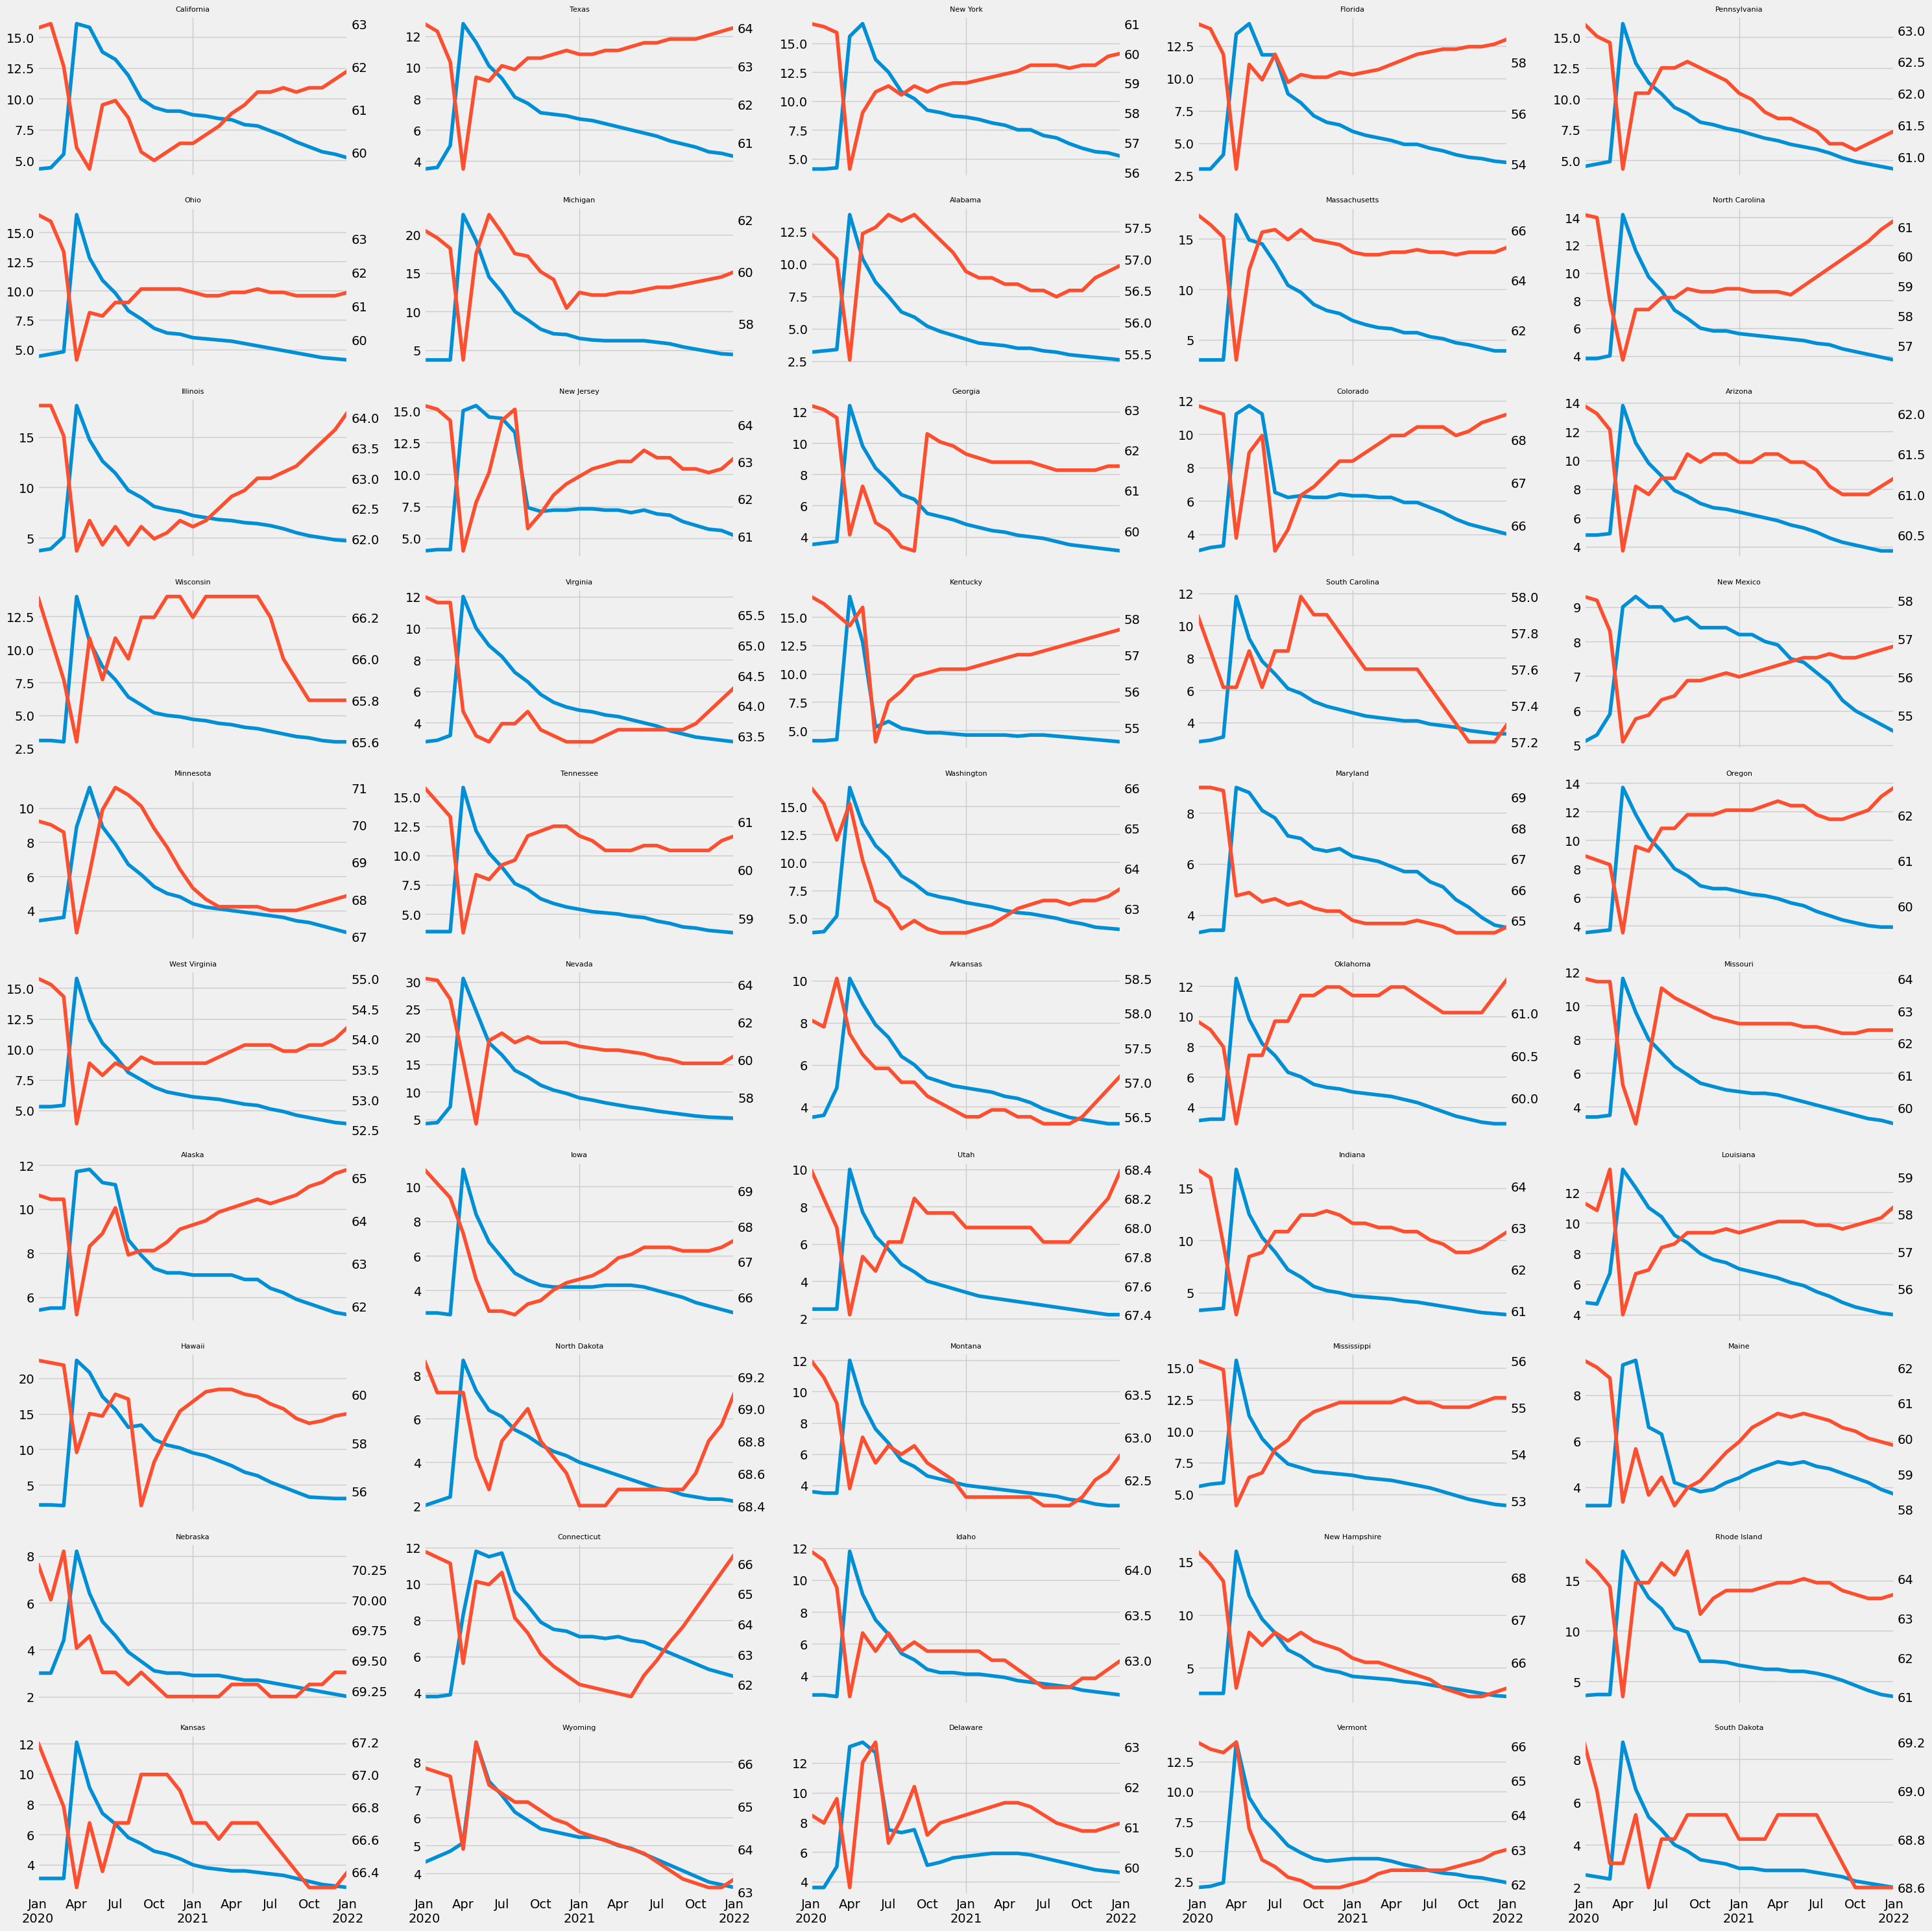

In [18]:
fig, axs = plt.subplots(10, 5, figsize=(30, 30), sharex=True)
axs = axs.flatten()

i = 0
for state in unemp_states.columns:
    if state == "District Of Columbia":
        continue
    ax2 = axs[i].twinx()
    unemp_states.query('index >= 2020 and index <= 2022')[state] \
        .plot(ax=axs[i], label='Unemployment')
    part_states.query('index >= 2020 and index <= 2022')[state] \
        .plot(ax=ax2, label='Participation', color=color_pal[1])
    ax2.grid(False)
    axs[i].set_title(state, fontsize=8)
    i += 1
plt.tight_layout()
plt.show()

### Plot for "District Of Columbia"

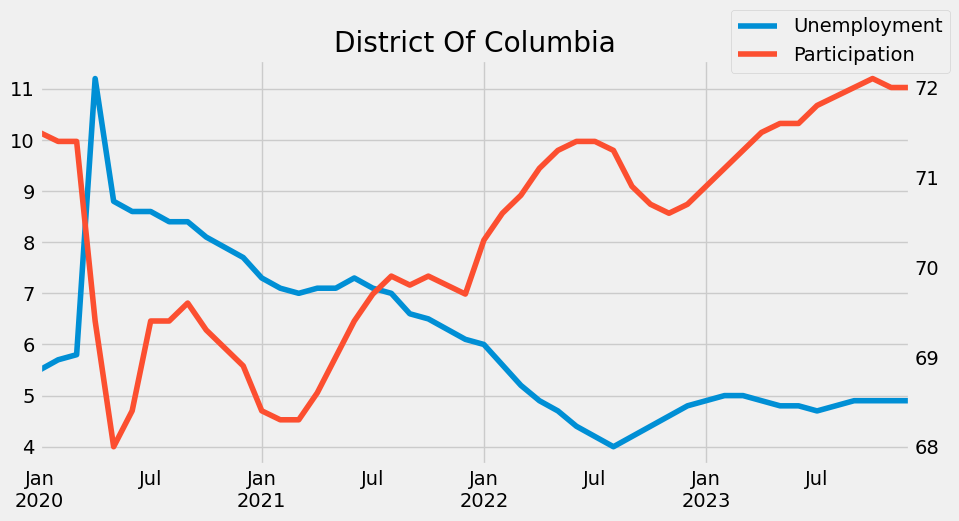

In [19]:
state_dc = 'District Of Columbia'
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
ax2 = ax.twinx()
unemp_states.query('index >= 2020 and index < 2024')[state_dc] \
    .plot(ax=ax, label='Unemployment')
part_states.query('index >= 2020 and index < 2024')[state_dc] \
    .plot(ax=ax2, label='Participation', color=color_pal[1])
ax2.grid(False)
ax.set_title(state_dc)
fig.legend(labels=['Unemployment','Participation'])
plt.show()